# Spatial mapping of cell types across the mouse brain (1/2) - cell2location

This notebook demonstrates how to use the **cell2location** model for mapping a single cell transcriptomic reference onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain (Kleshchevnikov et al., in preparation). 

## Loading packages and setting up GPU

First, we need to load the relevant packages and tell cell2location to use the GPU. cell2location is written in pymc3 language for probabilistic modelling that uses a deep learning library called theano for heavy computations. While the package works on both GPU and CPU, using the GPU significantly shortens the computation time for 10X Visium datasets  to 15-20 minutes per sample. Using the CPU is more feasible for smaller datasets with fewer spatial locations (e.g. Nanostring WTA technology). 

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

data_type = 'float32'

# this line forces theano to use the GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# if using the CPU uncomment this:
#os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'
#os.environ["OMP_NUM_THREADS"] = '8'

#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location

from matplotlib import rcParams
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


**Tips on initializing GPU** 
`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU. E.g. failure to use cuDNN will lead to significant slowdown.    
Do not forget to change `device=cuda0` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.    
You should see a message similar to the one below confirming that `theano` started using the GPU:
```
/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)
```

## Cell2location Outline

The cell2location workflow consists of two sections:


I. Spatially mapping cell types (this notebook):

1. Loading Visium data and single cell reference, QC
2. Exploring the data: UMAP of cells and locations
3. cell2location analysis in one step

II. Results and downstream analysis (the second notebook):

1. Loading cell2location results
2. Visialising cell locations
3. Automatic discrete region identification by clustering cell densities
4. Analyse cell type density gradients using diffusion maps
5. Identify co-occuring cell type combinations using matrix factorisation

## 1. Loading Visium data and single cell reference

In this tutorial, we use a paired Visium and snRNAseq reference dataset of the mouse brain (i.e. generated from adjacent tissue sections). There are two biological replicates and several tissue sections from each brain, totalling 5 10X visium samples. 

First, let's read the spatial Visium data from the 10X Space Ranger output and examine several QC plots. Here, we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/viseum_cortex_trial/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/processed_data/'
results_folder = '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/'

sample_data = pd.read_csv(sp_data_folder + 'Visum_mouse.csv')
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


Next, we load the mRNA count for each Visium mouse brain sample (i.e. section) and corresponding histology images into a single anndata object `adata`.

In [3]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'], 
    index_unique=None
)
obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Now let's look at QC: total number of counts and total number of genes per Visium sample.

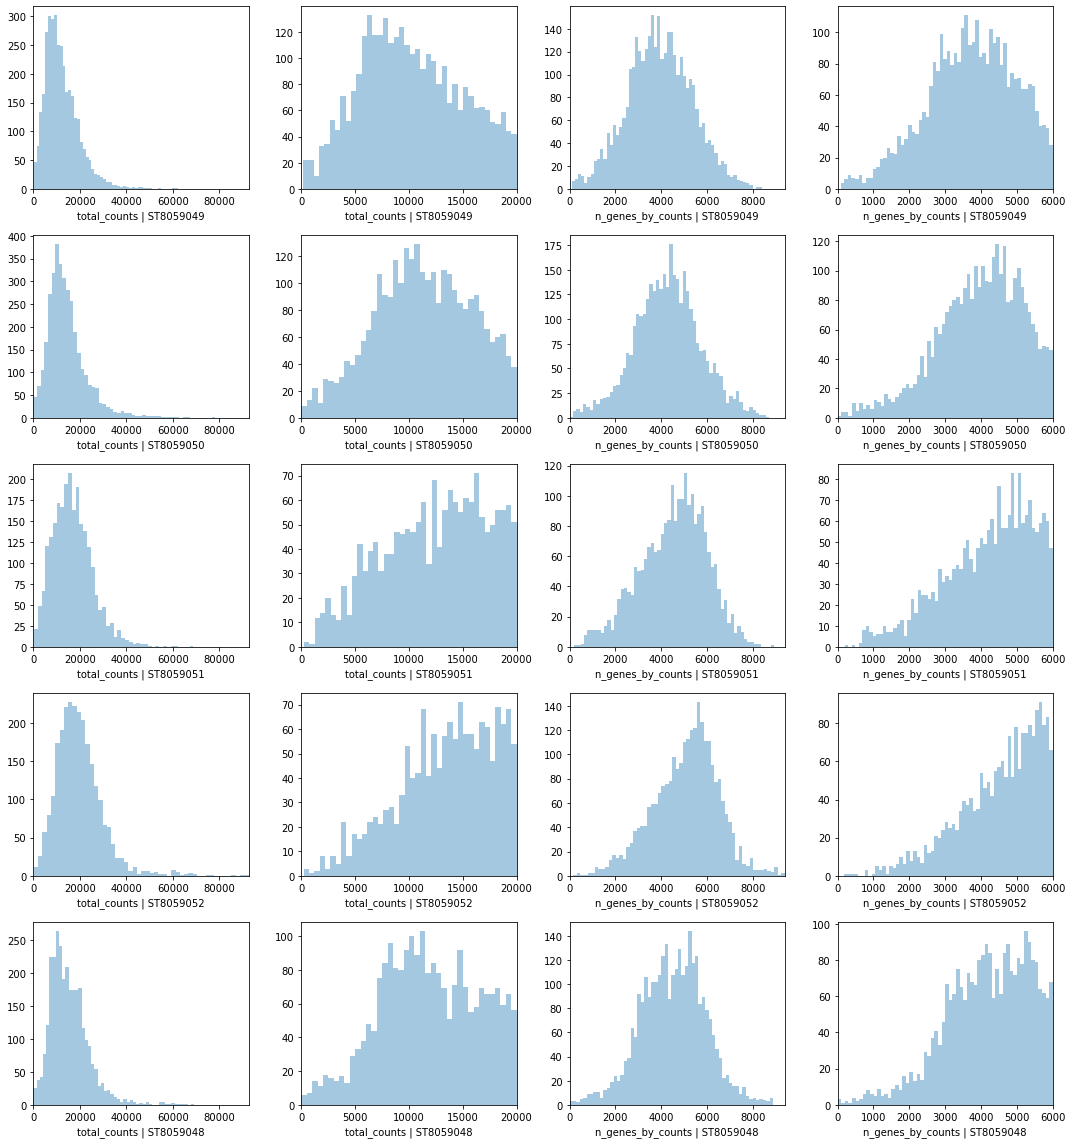

In [4]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

Next, we show how to plot these QC values over the histology image using standard scanpy tools

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name2' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'image_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'slide' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'position' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'SYMBOL' as categorical


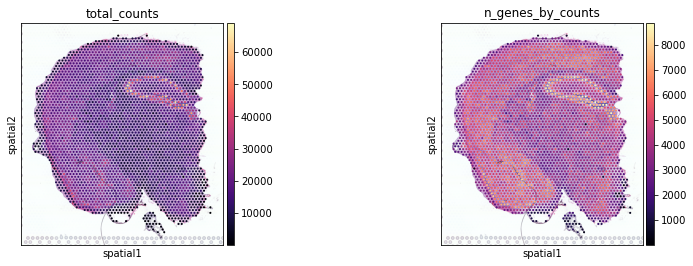

In [5]:
sc.pl.spatial(adata[adata.obs["sample"]==adata.obs["sample"].unique()[0], :],
              img_key = "hires", cmap='magma', 
              library_id=list(adata.uns['spatial'].keys())[0],
              color=['total_counts', 'n_genes_by_counts'], size=1,
              gene_symbols='SYMBOL')

Here we show how to use scanpy to plot the expression of individual genes without the histology image.

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name2' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'image_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'slide' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'position' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'SYMBOL' as categorical


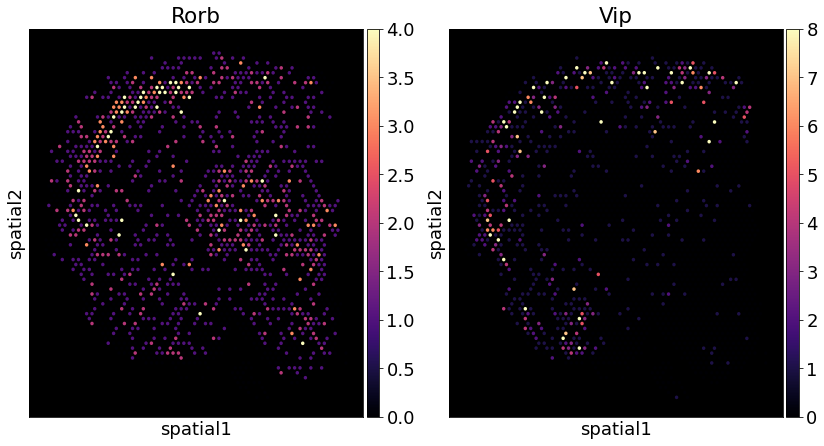

In [6]:
rcParams["axes.facecolor"] = "black"
rcParams["figure.figsize"] = [6,7]
rcParams["font.size"] = 18

sc.pl.spatial(adata[adata.obs["sample"]==adata.obs["sample"].unique()[0], :], 
              color=["Rorb", "Vip"], img_key=None, size=1,
              library_id=list(adata.uns['spatial'].keys())[0],
              vmin=0, cmap='magma', vmax='p99.0',
              gene_symbols='SYMBOL'
             )

Next, we load the pre-processed snRNAseq reference. Scanpy website has tutorials covering how to import other formats.

In [7]:
## snRNAseq reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "snRNA_s144600_raw_20200128.h5ad")

## Cell type annotations
labels = pd.read_csv(results_folder + 'snRNA_annotation_20200229.csv', index_col=0)

# remove cells that do not have a label
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['sample'].isin(['nan']),]

Add cell type labels as columns in `adata.obs`

In [8]:
adata_snrna_raw = adata_snrna_raw[labels.index,]
adata_snrna_raw.obs = pd.concat([labels, adata_snrna_raw.obs], axis=1)

Add counts matrix as `adata.raw` 

In [9]:
adata_vis = adata.copy()
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

Select two Visium samples to speed up the analysis, one from each biological replicate.

In [10]:
s = ['ST8059048', 'ST8059051']
adata_vis = adata_vis[adata_vis.obs['sample'].isin(s),:]

slides = {i: slides[i] for i in s}

## 2. Show UMAP of cells and locations

We can examine the cell composition of our data by using a standard scanpy workflow to generate a UMAP representation of the single cell data.

In [11]:
sc.pp.log1p(adata_snrna_raw)
sc.pp.highly_variable_genes(adata_snrna_raw, min_mean=0.0125, max_mean=5, min_disp=0.5)
sc.pp.scale(adata_snrna_raw, max_value=10)
sc.tl.pca(adata_snrna_raw, svd_solver='arpack', n_comps=70, use_highly_variable=True)
sc.pp.neighbors(adata_snrna_raw, n_neighbors = 15, n_pcs = 70, metric='cosine')
sc.tl.umap(adata_snrna_raw, min_dist = 0.3, spread = 1)

... storing 'annotation_1' as categorical


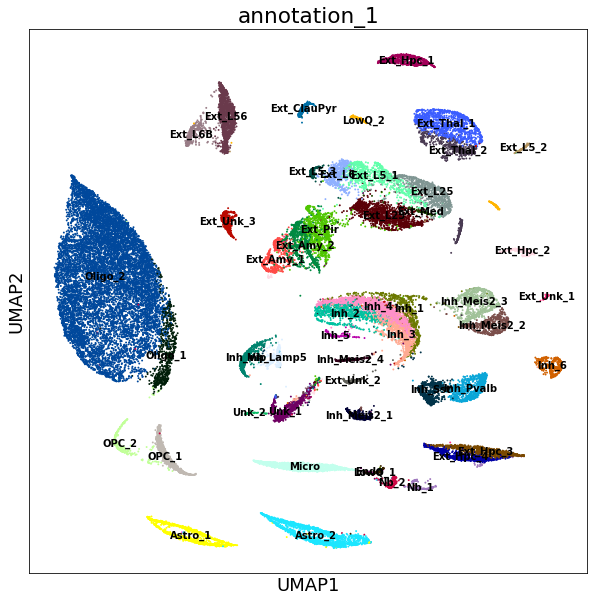

In [12]:
rcParams['figure.figsize'] = 10, 10
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_snrna_raw, color=['annotation_1'], size=15,
           color_map = 'RdPu', ncols = 1, legend_loc='on data',
           legend_fontsize=10)

Applying the same standard scanpy processing pipeline to the spatial Visium data can show sample to sample variability in your data. In this mouse brain dataset,  we see that many but not all spatial regions are represented in both samples. This makes sense because we are using 2 samples from biological replicated sectioned at a slightly different location along the anterior-posterior axis in the mouse brain. Some of the regions we captured change along that axis.

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


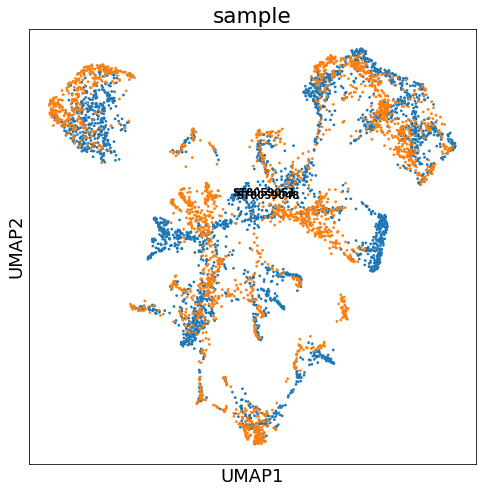

In [43]:
adata_vis_plt = adata_vis.copy()

# Log-transform (log(data + 1))
sc.pp.log1p(adata_vis_plt)

# Find highly variable genes within each sample
adata_vis_plt.var['highly_variable'] = False
for s in adata_vis_plt.obs['sample'].unique():
    
    adata_vis_plt_1 = adata_vis_plt[adata_vis_plt.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(adata_vis_plt_1, min_mean=0.0125, max_mean=5, min_disp=0.5, n_top_genes=1000)
    
    hvg_list = list(adata_vis_plt_1.var_names[adata_vis_plt_1.var['highly_variable']])
    adata_vis_plt.var.loc[hvg_list, 'highly_variable'] = True
    
# Scale the data ( (data - mean) / sd )
sc.pp.scale(adata_vis_plt, max_value=10)
# PCA, KNN construction, UMAP
sc.tl.pca(adata_vis_plt, svd_solver='arpack', n_comps=40, use_highly_variable=True)
sc.pp.neighbors(adata_vis_plt, n_neighbors = 20, n_pcs = 40, metric='cosine')
sc.tl.umap(adata_vis_plt, min_dist = 0.3, spread = 1)

rcParams['figure.figsize'] = 8, 8
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_vis_plt, color=['sample'], size=30,
           color_map = 'RdPu', ncols = 1, legend_loc='on data',
           legend_fontsize=10)

## 3. cell2location analysis in one step

cell2location is a Bayesian model that integrates single-cell RNA-seq (scRNA-seq) and multi-cell spatial transcriptomics to map cell types at scale (Fig 1A). cell2location leverages reference signatures that are estimated from scRNA-seq profiles, for example using conventional clustering followed by estimation of average gene expression profiles. Based on these reference signatures, mRNA contributions from each of the defined cell types are estimated at each location in the spatial data, which gives rise to both cell type proportions as well as absolute densities of cell types in a spatially resolved manner. Computationally, this is achieved via a hierarchical non-negative decomposition of the gene expression profiles at spatial locations (each with multiple cells) into the reference signatures of cell types and cell states (Fig 1B). 

Robustness of the model is enabled by modelling differences between technologies using scaling factors, and employing a flexible negative binomial error model to account for technical and unexplained variation. Finally, cell2location is computationally efficient, owing to variational approximate inference.

![Fig1](../images/Fig1_v2.png)   
Fig 1. Cell2location model for spatial mapping of comprehensive cell type references.    
A. Overview  of the spatial mapping workflow that is enabled by cell2location. Spatial transcriptomics data are decomposed into cell type abundance estimates, using a scRNA-seq based cell type reference from the same tissue.    
B. Basic principles of the strategy employed by cell2location.    

### Brief description of the model

Let $D=\{d_{s,g}\}$ be a $S \times G$ Spatial expression count matrix for locations $s=\{1..S\}$ and genes $g=\{1..G\}$. 

Cell2location models the elements of $D$ as Negative Binomial distributed, given an unobserved rate $\mu$ and a gene-specific over-dispersion parameter $\alpha_g$ which describes variance in expression of individual genes that is not unexplained by the regulatory programs: 
$$
D_{s,g} \sim \mathtt{NB}(\mu_{s,g}, \alpha_g) \\
$$

The spatial expression levels of genes $\mu_{s,g}$ in the rate space are modelled as the sum of five non-negative components:
$$
\mu_{s,g} = m_{g} \left (\sum_{f} {w_{s,f} \: g_{f,g}} \right) + l_s + s_{g}\\
$$

Here, $w_{s,f}$ denotes regression weight of each program $f$ at location $s$; 
$m_{g}$ denotes a gene-specific scaling parameter which accounts for difference in the global expression estimates between technologies;
$l_{s}$ and $s_{g}$ are additive components that capture background variation that is not explained by the bi-variate decomposition.

<div class="alert alert-block alert-success">
<b>Note!</b>
Cell2location employs informative priors on the prior on regression weight $w_{s,f}$ (number cells, located signatures, co-located combinations of programmes) and average change in sensitivity between technologies  $m_{g}$. This enables estimation of absolute cell density. These priors need to be modified for each tissue and the strategies for setting them are shown in code below.
</div>

Here we show how to perform the first step in one function run - train cell2location model to estimate cell abundances in each location. This workflow is wrapped into a singe pipeline function call:

In [14]:
sc.settings.set_figure_params(dpi = 100, color_map = 'RdPu', dpi_save = 100,
                              vector_friendly = True, format = 'pdf',
                              facecolor='white')

r = cell2location.run_cell2location(
    
      # Single cell reference data as anndata object (could also be pd.DataFrame with signatures)
      sc_data=adata_snrna_raw, 
      # Spatial data as anndata object
      sp_data=adata_vis,

      # the column in sc_data.obs that gives cluster idenitity of each cell
      summ_sc_data_args={'cluster_col': "annotation_1"},

      train_args={'use_raw': True, # By default uses raw slots in both of the input datasets.
                  'n_iter': 15000, # Increase the number of iterations if needed (see below)
                  'sample_name_col': 'sample'}, # Column in sp_data.obs with Sample ID

      # Number of posterios samples to use for estimating parameters,
      # reduce if not enough GPU memory
      posterior_args={'n_samples': 1000}, 

    
      export_args={'path': results_folder + 'std_model/', # path where to save results
                   'run_name_suffix': '' # optinal suffix to modify the name the run
                  },

      model_kwargs={ # Prior on the number of cells, cell types and co-located combinations
          
                    'cell_number_prior': {
                        # Use visual inspection of the tissue image to determine 
                        # the average number of cells per spot,
                        # an approximate count is good enough:
                        'cells_per_spot': 8, 
                        # Prior on the number of cell types (or factors) in each spot
                        'factors_per_spot': 7, 
                        # Prior on the number of correlated cell type combinations in each spot
                        'combs_per_spot': 2.5
                    },
          
                     # Prior on change in sensitivity between technologies
                    'gene_level_prior':{
                        # Prior on average change in expression level from scRNA-seq to spatial technology,
                        # this reflects your belief about the sensitivity of the technology in you experiment
                        'mean': 1/2, 
                        # Prior on how much individual genes differ from that average,
                        # a good choice of this value should be lower that the mean
                        'sd': 1/4
                    }
      }
)

### Summarising single cell clusters ###
### Creating model ### - time 0.04 min
### Analysis name: CoLocationModelNB4V2_50clusters_5396locations_11945genes
### Training model ###


Finished [100%]: Average Loss = 5.5133e+07


Finished [100%]: Average Loss = 5.5133e+07


None
### Sampling posterior ### - time 21.96 min
### Saving results ###


... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


### Ploting results ###
None
None
### Ploting posterior of W / cell locations ###
Consider running `set_figure_params(dpi_save=...)`, which will adjust `matplotlib.rcParams['savefig.dpi']`
### Done ### - time 23.6 min


The results are saved to:  

In [15]:
results_folder + 'std_model/' + r['run_name']

'/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4V2_50clusters_5396locations_11945genes'

Cell locations are added to `sp_data` as columns of `sp_data.obs` and the estimates of all parameters of the model are exported to `sp_data.uns['mod']`. This anndata object and 4 csv files `W.csv` / `W_q05.csv` with cell locations are  saved to the results directory:

- sp.h5ad - Anndata object with all results and spatial data.   
- W_cell_density.csv - density of each cell type regulatory programme, mean of the posterior distribution.   
- W_cell_density_q05.csv - density of each cell type regulatory programme, 5% quantile of the posterior distribution representing confident cell density level.   
- W_mRNA_count.csv - mean of the posterior distribution representing the number of mRNA molecules assigned to each cell type.   
- W_mRNA_count_q05.csv - 5% quantile of the posterior distribution, representing the number of mRNA molecules confidently assigned to each cell type.   

The same quantities are also plotted for each regulatory programme (save to `r['run_name']/plots/scanpy`, on black background and overlayed on the histology image paired with each sample (`histo_` prefix).


The downstream analysis notebook adds more results to:
- sp_with_clusters.h5ad

When `'save_model': True`, the trained model `r['mod']` is also saved as a pickle file. You can load the model later and continue training. 

In [16]:
r = {'run_name': 'CoLocationModelNB4V2_50clusters_5396locations_11945genes'}

#### Evaluating training

Now we need to check if our model has trained successfully by examining a few diagnosic plots. 

First, we look at the ELBO loss / cost function over training iterations. This plot omits the first 20% of training iterations during which loss changes by orders of magnitude. Here we see that the model converged by the end of training, some noise in the ELBO loss function is acceptable. If there are large changes during the last few thousands of iterations we recommend increasing the `'n_iter'` parameter.

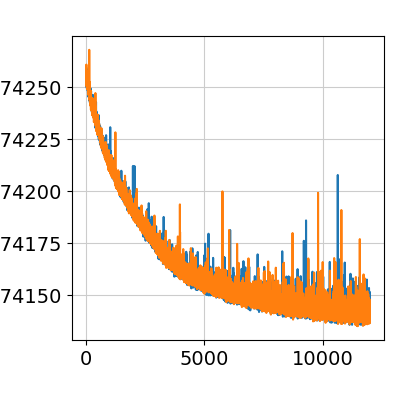

In [17]:
from IPython.display import Image
Image(filename=results_folder + 'std_model/'+r['run_name']+'/plots/training_history_without_first_20perc.png',
      width=400)

We also need to evaluate the reconstruction accuracy: how well reference regulatory programmes signatures explain spatial data by comparing expected value of the model (Negative Binomial mean) to observed count of each gene across locations. The ideal case is a perfect diagonal 2D histogram plot (every point is a combination of genes and locations). 

A very fuzzy diagonal or large deviations of some genes and locations from the diagonal plot indicate that the reference signatures are incomplete. The reference could be missing certain cell types entirely (e.g. FACS-sorting one cell lineage) or clustering could lack enough granularity (e.g. mapping 5 broad cell types).

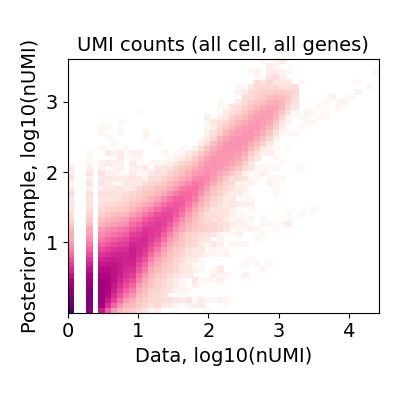

In [18]:
Image(filename=results_folder + 'std_model/'+r['run_name']+'/plots/data_vs_posterior_mean_Poisson_rate.png',
      width=400)

Finally, we need to evaluate robustness of the identified locations by comparing consistency of inferred locations between two independent training restarts (X- and Y-axis). The plot below shows the correlation (color) between cell abundance profiles in 2 training restarts. Some cell types can be correlated their abundance patterns but excessive deviations from diagonal would indicate instability of the solution (not seen so far).

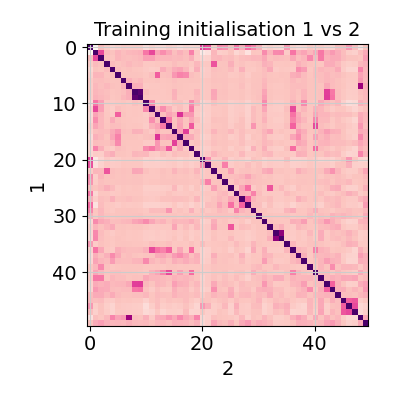

In [19]:
Image(filename=results_folder + 'std_model/'+r['run_name']+'/plots/evaluate_stability.png',
      width=400)

Modules and their versions used for this analysis

In [20]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]
ipykernel 5.3.0
ipykernel._version 5.3.0
json 2.0.9
re 2.2.1
IPython 7.15.0
IPython.core.release 7.15.0
logging 0.5.1.2
zlib 1.0
traitlets 4.3.3
six 1.15.0
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
traitlets._version 4.3.3
decorator 4.4.2
argparse 1.1
IPython.core.crashhandler 7.15.0
pygments 2.6.1
pexpect 4.8.0
ptyprocess 0.6.0
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.5
wcwidth 0.2.4
pkg_resources._vendor.six 1.10.0
pkg_resources.extern.six 1.10.0
pkg_resources._vendor.appdirs 1.4.3
pkg_resources.extern.appdirs 1.4.3
pkg_resources._vendor.packaging 16.8
pkg_resources._vendor.packaging.__about__ 16.8
pkg_resources.extern.packaging 16.8
pkg_resources._vendor.pyparsing 2.2.1
pkg_resources.extern.pyparsing 2.2.1
jedi 0.17.1
parso 0.7.0
urllib.request 3.7
jupyter_client 6.1.3
jupyter_client._version 6.1.3
zmq 19.0.1
cty